# Úvod do konvoluce

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray

import ans

In [3]:
plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Testovací obrázek a filtry

Nejprve si načteme nějaký testovací obrázek. Funkce `imread` z knihovny skimage vrátí barevný RGB obrázek jako numpy `ndarray` s rozměry *výška x šířka x kanály* s datovým typem `uint8`. Obrázek dále převedeme do šedi a vydělíme 255 kvůli převedení do rozsahu 0...1 a přetypování na Python `float`, aby nedocházelo k přetékání.

In [6]:
rgb_test = imread('../data/happy-green-frog.jpg') / 255.
rgb_test.dtype, rgb_test.shape

(dtype('float64'), (500, 500, 3))

In [7]:
gray_test = rgb2gray(rgb_test)
gray_test.dtype, gray_test.shape

(dtype('float64'), (500, 500))

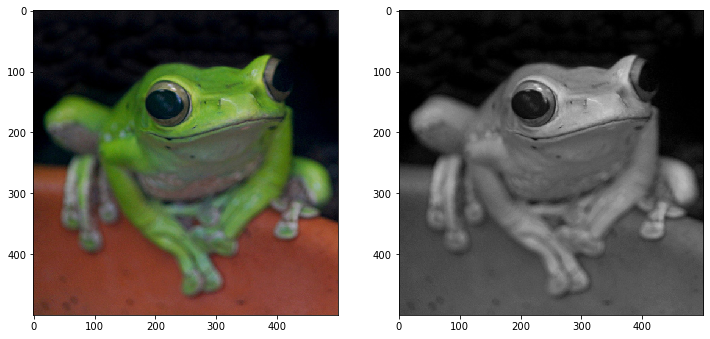

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(rgb_test)
plt.subplot(1, 2, 2)
plt.imshow(gray_test)
plt.show()

Konvoluce má dva operandy: zdrojový signál (orbázek) a jádro (kernel) konvoluce, často označované také jako konvoluční filtr. Oba operandy si musí odpovídat svými rozměry. Pokud budeme uvažovat šedotónový obrázek reprezentovaný 2D maticí, filtr bude rovněž matice. RGB obrázky reprezentované 3D maticí $H × W × C$ (pro RGB platí $C=3$) budou konvolvovány s 3D filtrem o rozměrech $K × L × C$.

Filtry si tentokrát vytvoříme jako numpy `ndarray`, abychom mohli vyzkoušet klasickou konvoluci v knihovnách scipy a OpenCV.

In [9]:
# Sobeluv filtr v horizontalnim smeru (detekuje vertikalni hrany)
W_sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
], dtype=np.float)

# Sobeluv filtr ve vertikalnim smeru (detekuje horizontalni hrany)
W_sobel_y = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1],
], dtype=np.float)

# prumerovaci filtr 9x9
W_blur = 1. / 81. * np.ones((9, 9))

## Dvourozměrná konvoluce ve scipy: 2D vstup, 2D filtr

Konvoluce v modulu `scipy.signal` bohužel zvládá pouze čistě 2D konvoluci, tzn. že jak obrázek, tak filtr musí být dvourozměrné matice. RGB obrázky nejsou podporovány a konvoluce tak musí být provedena pro každý kanál zvlášť. To zní jako příliš práce, a tak si zde ukážeme pouze podporovanou variantu.

In [10]:
from scipy import signal

Následující kód projede všechny filtry, provede jejich konvoluci se vstupním obrázkem a výsledek zobrazí.

Konvoluce pomocí funkce `convolve2d` podobně jako její ekvivalent v MATLABu `conv2` umožňuje nastavit velikost oblasti výpočtu konvoluce. Chování určuje parametr `mode`:

  - `mode='full'`: filtr se svým středem posouvá přes celý vstupní obrázek i nastavené hodnoty (padding), kdykoliv se filtr "dotýká" vstupu třeba jen jedním pixelem $\rightarrow$ výstup je prostorově větší než vstup
  - `mode='same'`: filtr se svým středem příkládá na všechny pixely vstupu tak, aby výsledek konvoluce měl stejný rozměr jako vstup
  - `mode='valid'`: filtr se přikládá na obrázek pouze tehdy, pokud "nepřečuhuje" a výsledek je tedy menší než vstup

Pokud filtr "přečuhuje" mimo obrázek, chybějící hodnoty vstupu se doplní typicky nulami (padding). Způsob doplnění lze nastavit argumenty `boundary` a `fillvalue`.

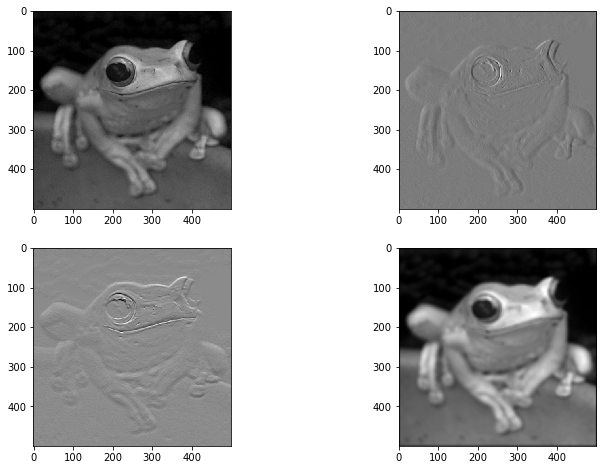

In [11]:
for i, kernel in enumerate((None, W_sobel_x, W_sobel_y, W_blur)):
    if kernel is None:
        # neni filtr --> neprovadej konvoluci = zobrazi se nezmeneny obrazek
        output = gray_test.copy()
    else:
        # `mode='same'` --> vystup bude mit stejny rozmer jako vstup
        # `boundary='fill', fillvalue=0.` --> tzv. zero padding, tj. nastavi obrazek nulami
        output = signal.convolve2d(gray_test, kernel, mode='same', boundary='fill', fillvalue=0.)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(output)
plt.show()

Ověřme si rozměry vstupu a výstupu:

In [12]:
print(gray_test.shape)
print(output.shape)

(500, 500)
(500, 500)


## Dvourozměrná konvoluce v OpenCV: 3D vstup, 2D filtr

OpenCV je populární knihovna pro zpracování obrazu a počítačové vidění. Je vyvíjená již 15 let a obsahuje velké množství algoritmů např. pro geometrické a jasové transformace obrázků, detekci a rozpoznávání objektů či stereo-vidění a 3D rekonstrukci. Kromě C++, ve kterém je napsaná, nabízí wrappery i pro další jazyky, mezi nimi i Python.

In [13]:
import cv2

OpenCV implementuje 2D konvoluci funkcí `cv2.filter2D`, která na rozdíl od `scipy.signal.convolve2d` podporuje i RGB obrázky. Pokud jako vstup zadáme RGB obrázek, tedy **3D** matici, a **2D** filtr, stane se přesně to, co bychom při použití `scipy.signal.convolve2d` museli dělat ručně, tj. **konvoluce se provede pro každý kanál zvlášť**. Výstupem tedy bude opět barevný obrázek (všimněme si barev u výsledných hranových obrázků po spuštění následující buňky).

OpenCV neumožňuje volit velikost výstupu a vždy zachovává rozměry vstupu. Funguje tedy v režimu "valid". Hodnoty paddingu lze měnit parametry `delta` a `borderType`, přičemž ve výchozím stavu OpenCV nastavuje nikoliv nulami, nýbrž rozšiřuje obrázek o hodnoty na okraji obrazu. Nastavení nulami lze zajistit parametry `delta=0` a `borderType=cv2.BORDER_CONSTANT`.

Pozn.: matplotlib očekává, že RGB obrázky budou buď typu `uint8` s rozsahem 0..255, nebo `float` v intervalu 0..1. Nám operací vznikne `float`, jenž může a v případě Sobelových filtrů i bude obsahovat záporné hodnoty. Před zobrazením tedy výstup normalizujeme do rozsahu 0..1.

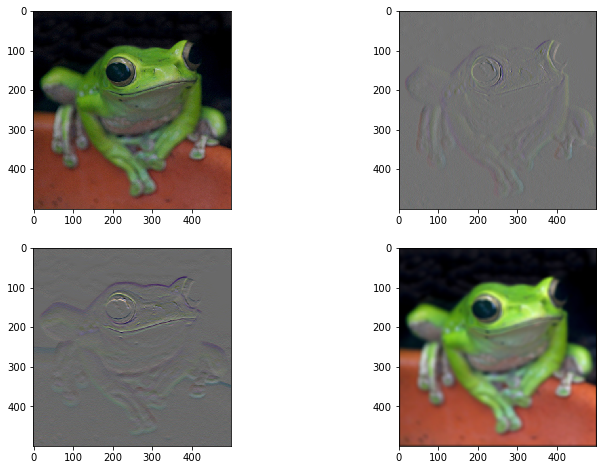

In [14]:
for i, kernel in enumerate((None, W_sobel_x, W_sobel_y, W_blur)):
    if kernel is None:
        # neni filtr --> neprovadej konvoluci = zobrazi se nezmeneny obrazek
        output = rgb_test.copy()
    else:
        # defaultne ma vystup z `cv2.filter2D` stejne rozmery jako vstup
        output = cv2.filter2D(rgb_test, -1, kernel, delta=0, borderType=cv2.BORDER_CONSTANT)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow((output - output.min()) / (output.max() - output.min() + 1e-6))
plt.show()

Opět zkontrolujeme velikost výstupu:

In [ ]:
print(rgb_test.shape)
print(output.shape)

## Dvourozměrná konvoluce v PyTorch: 2D vstup, 2D filtr

In [16]:
import torch
import torchvision
import torch.nn.functional as F

Konvoluce v PyTorch je o něco obtížnější, protože framework je primárně určen pro učení neuronových sítí, ne k práci s obrázky. Vše je uzpůsobeno pro trénování metodou minibatch SGD, což znamená, že PyTorch očekává 4D vstup formátu *dávka x kanály x výška x šířka*. Pokud tedy chceme provést konvoluci s šedotónovým 2D obrázkem `gray_test`, musíme přidat dvě dimenze navíc. Kromě toho funkce pracují nad PyTorch tensory, nikoliv numpy poli, a je tedy nutná i konverze.

Pozn.: přidat dimenzi v numpy lze více způsoby, nejjednodušší je indexace s `None`, které se chová jako `np.newaxis`. Lze však využít i např. funkce `reshape`, [`expand_dims`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html), nebo přidat dimenzi až po konverzi do PyTorch tensoru.

In [19]:
inputs = torch.from_numpy(gray_test[None, None])
inputs.dtype, inputs.shape

(torch.float64, torch.Size([1, 1, 500, 500]))

S filtrem je to také obtížnější. Ten musí být formátu *výstupní\_kanály x vstupní\_kanály x filtr\_výška x filtr\_šířka*.

In [20]:
weights = torch.from_numpy(W_sobel_x[None, None])
weights.dtype, weights.shape

(torch.float64, torch.Size([1, 1, 3, 3]))

PyTorch definuje většinu operací v modulu `torch.nn.functional`, které pak obaluje vrstvami definovanými v modulu `torch.nn`. Pokud nechceme vytvářet vrstvu, ale pouze provést konvoluci nějakého vstupu a nějakého filtru, zavoláme funkci `conv2d`.

In [21]:
# padding=1 --> hodnota 1 je zaokrouhlena polovina velikosti filtru --> zachova se velikost vstupu
outputs = F.conv2d(inputs, weights, padding=1)

In [22]:
print(inputs.shape)
print(outputs.shape)

torch.Size([1, 1, 500, 500])
torch.Size([1, 1, 500, 500])


Před zobrazením musíme převést zpět do numpy.

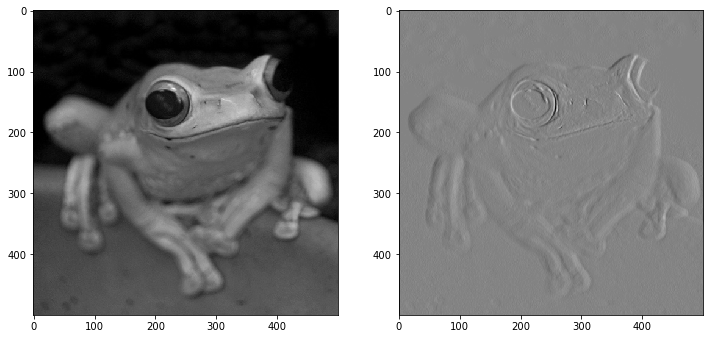

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(gray_test)
plt.subplot(1, 2, 2)
plt.imshow(outputs.data.numpy()[0, 0, :, :])
plt.show()

## Dvourozměrná konvoluce v PyTorch: 3D vstup, 3D filtr (barevný RGB obrázek)

Vyzkoušíme si i 2D konvoluci RGB obrázku, která se chová jinak, než co jsme doposud zkoušeli. V PyTorch je 2D konvouce vícekanálových obrázků v podstatě 3D konvoluce s filtrem, který má v třetím rozměru odpovídajícímu kanálům stejnou velikost jako vstup (zatímco v $xy$ je např. $3×3$, přičemž obrázek např. $640×480$). Tedy např. pokud má obrázek 3 kanály, pak i filtr musí mít 3 kanály. Jedná se proto o jiný případ než konvoluce v OpenCV, kde byl vstup 3D, filtr 2D a konvoluce se provedla zvlášť po jednotlivých kanálech.

Vstup tentokrát bude RGB, tedy 3D. Jak jsme si mohli všimnout výše, v PyTorch je RGB obrázek reprezentován ve formátu *kanály x výška x šířka*, tj. s **kanály jako první dimenzí!** Formát je tedy opačný oproti běžně používaným knihovnám jako OpenCV nebo skimage (scipy). Před konvolucí proto přeházíme dimenze funkcí `transpose`, která přejímá jako argumenty indexy jednotlivých dimenzí tak, jak mají nově jít za sebou.

In [24]:
inputs = rgb_test.transpose(2, 0, 1)
inputs = torch.from_numpy(inputs[None])
inputs.shape

torch.Size([1, 3, 500, 500])

Pokud je vstup RGB, tedy 3D, pak i filtr musí být 3D.

Pozn.: Tensor obrázku `inputs` je technicky 4D, kde první dimenze je batch indexující jednotlivé obrázky. Podobně je tomu tak u tensoru filtru `weights`, který je rovněž 4D s tím, že první dimenze indexuje samotné filtry, pokud bychom chteli provádět konvoluci s více filtry najednou (více dále).

In [25]:
weights = np.stack((W_sobel_x, W_sobel_x, W_sobel_x))[None]
weights = torch.from_numpy(weights)
weights.shape

torch.Size([1, 3, 3, 3])

In [26]:
# padding=1 --> hodnota 1 je zaokrouhlena polovina velikosti filtru --> zachova se velikost vstupu
outputs = F.conv2d(inputs, weights, padding=1)

In [27]:
print(inputs.shape)
print(outputs.shape)

torch.Size([1, 3, 500, 500])
torch.Size([1, 1, 500, 500])


Všimněme si, že výstup má pouze jeden kanál! To proto, že nedochází k sumaci pouze v $x$ a $y$, ale i v kanálech. A jelikož počet výstupních kanálů odpovídá počtu použitých filtrů a my provádíme konvoluci pouze jedním (byť 3D) Sobelovým filtrem, výstup má pouze jeden kanál.

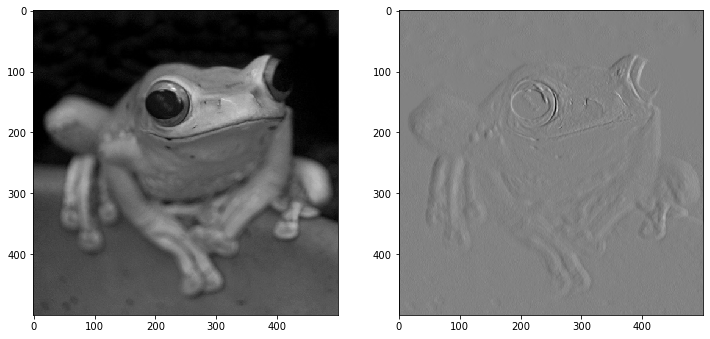

In [28]:
plt.subplot(1, 2, 1)
plt.imshow(gray_test)
plt.subplot(1, 2, 2)
plt.imshow(outputs.numpy()[0, 0, :, :])
plt.show()

## Konvoluce po jednotlivých kanálech

Jako cvičení k pochopení konvoluce nyní máte za úkol napodobit chování OpenCV, tj. **udělat konvoluci RGB obrázku po jednotlivých kanálech** pomocí PyTorch funkce `conv2d` s filtrem `W_sobel_x` jako v sekci [Konvoluce v OpenCV: 3D vstup, 2D filtr](#Dvourozměrná-konvoluce-v-OpenCV:-3D-vstup,-2D-filtr). Můžete použít `for` cyklus. Stačí pouze `W_sobel_x`, tj. výstupem bude jediný barevný hranový obrázek `output` s rozměry a datovým typem stejnými jako `rgb_test`.

In [109]:
target = cv2.filter2D(rgb_test, -1, W_sobel_x, delta=0, borderType=cv2.BORDER_CONSTANT)
target.dtype, target.shape

(dtype('float64'), (500, 500, 3))

In [111]:
#################################################################
# ZDE DOPLNIT
Sobel_tensor = torch.from_numpy(W_sobel_x[None])
out_tensor = torch.zeros(inputs.shape)

for i in range(3):
    conv = F.conv2d(inputs[0][i][None][None], Sobel_tensor[None], padding=1)
    out_tensor[0][i] = conv[0][0]
output = out_tensor[0].numpy().transpose(1, 2, 0)
#################################################################

Rozdíl mezi výsledkem (`output`) a konvolucí v OpenCV (`target`) musí být nula!

In [112]:
print('Rozdil: ' + str(np.sum(np.abs(target - output))))

Rozdil: 0.001144803088885732


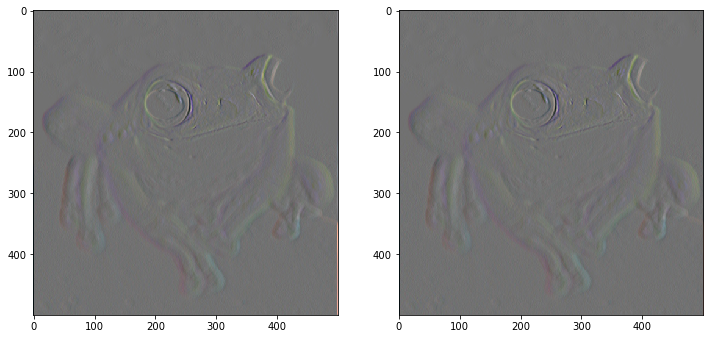

In [113]:
plt.subplot(1, 2, 1)
plt.imshow((target - target.min()) / (target.max() - target.min() + 1e-6))
plt.subplot(1, 2, 2)
plt.imshow((output - output.min()) / (output.max() - output.min() + 1e-6))
plt.show()

## Konvoluce s více filtry najednou

Druhé cvičení bude zreplikovat v PyTorch pokus, který jsme provedli se `scipy.signal.convolve2d`. **Proveďte tedy konvoluci vstupního šedotónového 2D obrázku se všemi čtyřmi (None, W_sobel_x, W_sobel_y, W_blur) filtry najednou!** Ano, i `None` filtr (tedy bez filtrace) zapište v maticové podobě. Omezení samozřejmě je, že všechny filtry musí být stejně velké, a tedy i průměrovací filtr musí být 3x3 a nestačí tak pouze vzít matici `W_blur`.

Nesmíte použít žádný `for` cyklus! Postup:
1. vytvoříte vstup `inputs`,
2. vytvoříte matici filtrů `weights`,
3. zavoláte `outputs = F.conv2d(...)`,
4. převedete do numpy,
5. a zobrazíte jednotlivé kanály subplotem jako obvykle

Výsledkem bude proměnná s názvem `outputs`: numpy `ndarray` typu `double` (`np.float64`) s rozměry *4 x výška x šířka*.

In [154]:
#################################################################
# ZDE DOPLNIT
inputs = torch.from_numpy(gray_test[None][None])
print(inputs.shape)

Sobel_x_tensor = torch.from_numpy(W_sobel_x)
Sobel_y_tensor = torch.from_numpy(W_sobel_y)
Blur_tensor = torch.ones(3,3) / 9.
None_tensor = torch.zeros(3,3)
None_tensor[1, 1] = 1

weights = torch.stack((Sobel_x_tensor, Sobel_y_tensor, Blur_tensor, None_tensor))[None].transpose(1, 0)


outputs = F.conv2d(inputs, weights, padding=1)[0, :, :, :].numpy()

#################################################################

torch.Size([1, 1, 500, 500])


Vykreslení:

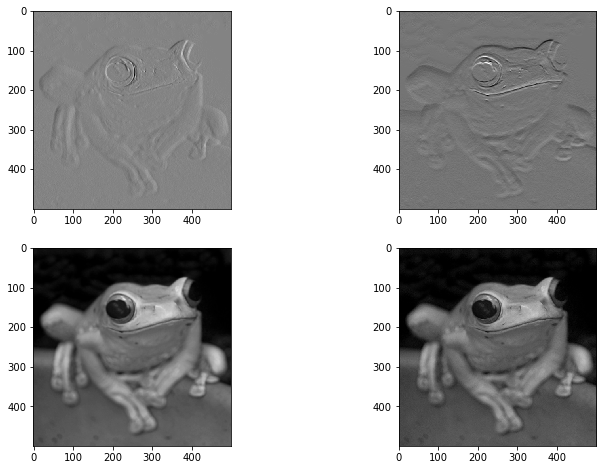

In [153]:
for i, chnl in enumerate(outputs):
    plt.subplot(2, 2, i + 1)
    plt.imshow((chnl - chnl.min()) / (chnl.max() - chnl.min() + 1e-6))
plt.show()

## Konvoluce jako vrstva

Pomocí `F.conv2d` pro dopředný průchod a `F.conv_transpose2d` pro zpětný průchod odvoďte vlastní konvoluční vrstvu typu `ans.Layer`, kterou bude možné použít v trénovacím procesu z minulého cvíčení [multilayer-perceptron-lab](multilayer-perceptron-lab.ipynb). Pro zjednodušení uvažujte pouze jednotkový krok (stride) a padding takový, aby zachovával velikost vstupu.

**Dopředný průchod**

Výsledek pro pixel na pozici $(u, v)$ $g$-tého kanálu je
$$z_{guv} = \sum_{i=1}^{K}\sum_{j=1}^{K}\sum_{c=1}^{C}{w_{gcij} x_{c,u+i,v+j}}$$
Ve vzorci uvažujeme
- $x$ ... vstup s rozměry $C × M × L$, kde $C$ je počet kanálů a $M × L$ je rozlišení (řádky x sloupce)
- $w$ ... tensor vah konv. filtrů s rozměry $G × C × K × K$, kde $G$ je počet filtrů a $K$ jejich velikost
- $z$ ... výstupní tensor s rozměry $G × U × V$, kde $U × V$ je výstupní rozlišení (v úloze uvažujeme $U = M$ a $V = L$)

Vzorec platí pro jeden obrázek v dávce a v kódu bude mít vstup $x$ o jeden rozměr víc (index v dávce). Vše implementuje automaticky funkce `F.conv2d` knihovny PyTorch.

**Zpětný průchod**

Gradient na **vstup** je transponovaná konvoluce příchozího gradientu ${\partial L} / {\partial z_{uv}}$ s vahami filtru $w$. Operaci implementuje PyTorch funkce `F.conv_transpose2d`.

Gradient na **váhy** je
$$\frac{\partial L}{\partial w_{gcij}} = \sum_{u=1}^{U}\sum_{v=1}^{V}{\frac{\partial L}{\partial z_{guv}}x_{c,i+u,j+v}}$$
kde rozměr příchozího gradientu je totožný s rozměrem výstupu $z$ dopředného kroku. Vzorec opět platí pouze pro jeden pár vstup-výstup! Gradient pro celou dávku bude jednoduše součet dílčích gradientů.



In [193]:
class Conv2D(ans.Layer):
    
    def __init__(self, in_channels, out_channels, kernel_size, weight_scale=1e-3):
        super().__init__()
        
        self.pad = kernel_size // 2
        
        self.params = {
            'weights': weight_scale * torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        }
        
    
    def forward(self, inputs):

        #################################################################
        # ZDE DOPLNIT
        
        w = self.params['weights']
        pad = self.pad
        
        self._cache = {
            "inputs": inputs
        }
        
        outputs = F.conv2d(inputs, w, padding=pad)            
        
        #################################################################

        return outputs
    
    def backward(self, doutputs):
        
        #################################################################
        # ZDE DOPLNIT
        # gradient na vstup
        w = self.params['weights']
        dinputs = F.conv_transpose2d(doutputs, w, padding=1)
        
        #################################################################
        
        inputs = self._cache['inputs']
        N, G, U, V = doutputs.shape
        _, C, _, _ = self.params['weights'].shape
        
        # gradient na vahy
        dweights = torch.zeros_like(self.params['weights'])
        for n in range(N):
            for g in range(G):
                for c in range(inputs.shape[1]):
                    input_n_c = inputs[n, c, :, :][None][None]
                    dgrad_n_g = doutputs[n, g, :, :][None][None]
                    
                    grad_g_c = F.conv2d(input_n_c, dgrad_n_g, padding=1)
                    dweights[g ,c, :, :] += grad_g_c[0, 0]
                    
                    #################################################################
                    # ZDE DOPLNIT
                    
                    # doporuceny postup:
                    # vzit n-ty vstup, c-ty kanal
                    # vzit n-ty prichozi gradient, g-ty kanal
                    # provest jejich 2D konvoluci (operandy musi byt 4D)
                    #   --> vysledek je 2D (gradient na c-ty kanal g-teho filtru)
                    # vysledny gradient pricist (scitani pres batch) na odpovidajici pozici do `dweights` 
                    
                    #################################################################
        
        return dinputs, {'weights': dweights}

In [156]:
# pro gradient check je dobre zvysit presnost
torch.set_default_dtype(torch.double)

In [194]:
# overime na male davce
inputs = torch.randn(4, 3, 8, 8)


# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
doutputs = torch.randn(4, 2, 8, 8)

# instance vrstvy
conv_layer = Conv2D(3, 2, 3)


# krok vypoctu numerickeho gradientu nastavime manualne
grads, grads_num = ans.check_gradients(conv_layer, inputs, doutputs)

dinput1 error:  5.179464177486814e-12
dweights error:  1.47410476593352e-14
